## Initial notebook

In [1]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [3]:
def simulate_sparsity(data, sparsity=0.9):
    # Create a binary mask with the given sparsity
    mask = (torch.rand(data.shape) > sparsity).float()
    return data * mask, mask

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # tensors
])

# Load MNIST data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
data_iter = iter(train_loader)
images, labels = next(data_iter)

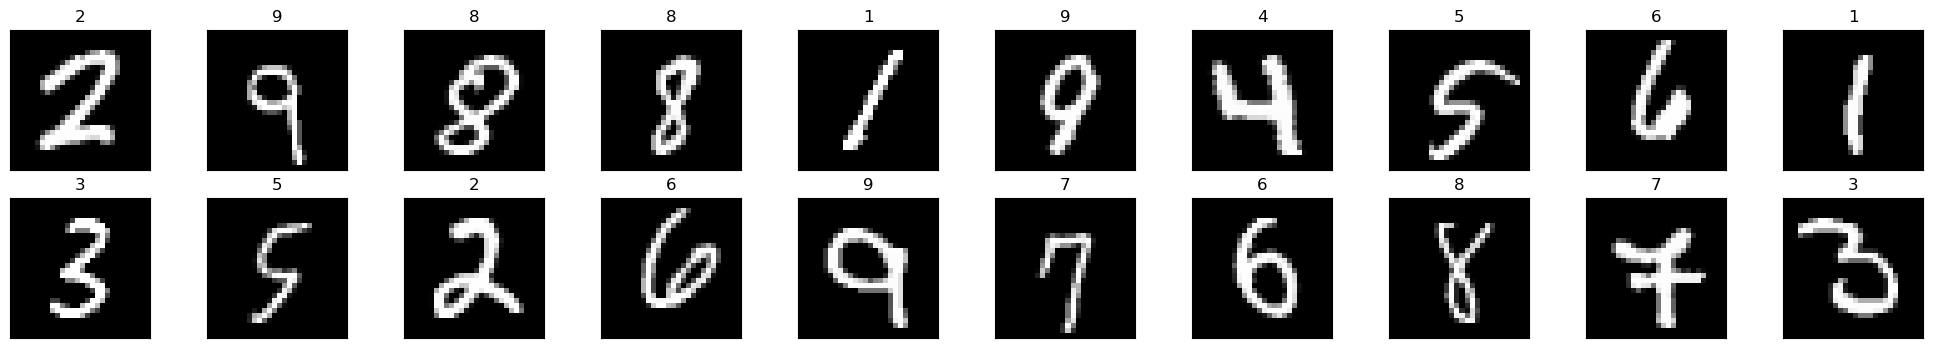

In [5]:
def visualize_data(data_loader):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)  # Get a batch of images and labels
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])  # Cast columns to int
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(labels[idx].item())

visualize_data(train_loader)


In [6]:
def create_sparse_representation(images, sparsity=0.5):
    batch_size, channels, height, width = images.size()
    # Generate random masks for each image in the batch
    masks = torch.rand(batch_size, 1, height, width) > sparsity
    sparse_images = images * masks
    return sparse_images, masks.float()

def visualize_sparse_images(sparse_images, labels, num_images=20):
    sparse_images = sparse_images.numpy()
    labels = labels.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in range(num_images):
        ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(sparse_images[idx]), cmap='gray')
        ax.set_title(labels[idx])
    plt.show()




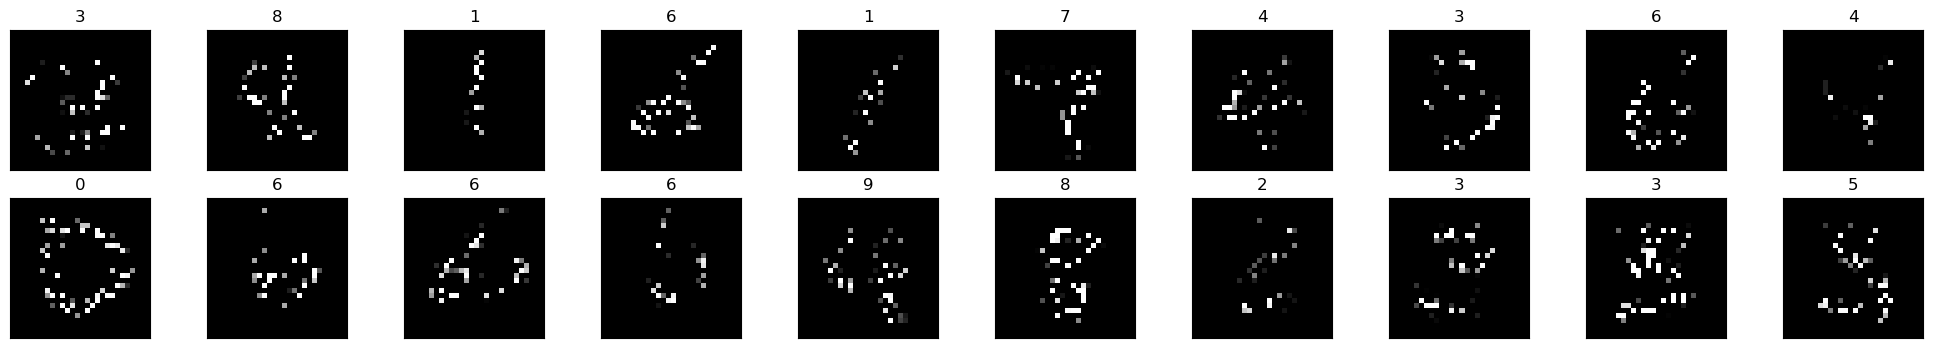

In [7]:
# Fetch a batch from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Create sparse images
sparse_images, masks = create_sparse_representation(images, sparsity=0.8)
visualize_sparse_images(sparse_images, labels)


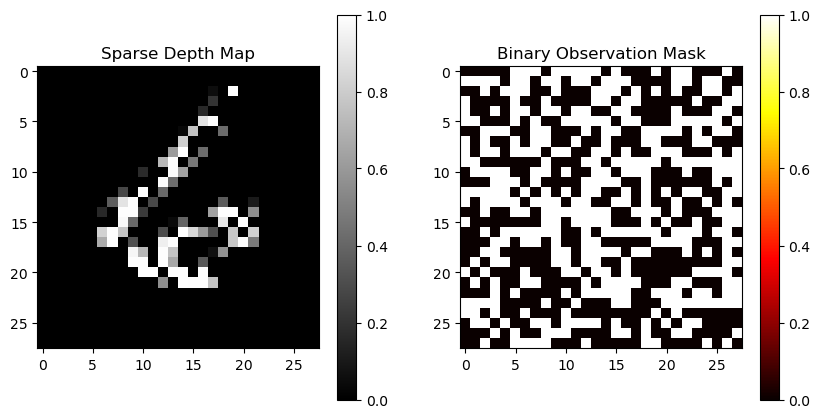

In [8]:
def create_sparse_depth_map_and_mask(depth_map, sparsity=0.5):
    mask = torch.rand_like(depth_map) > sparsity  # Create binary mask with given sparsity level
    sparse_depth_map = depth_map * mask.float()  # Apply mask to create sparse depth map
    return sparse_depth_map, mask

data_iter = iter(train_loader)
depth_maps, labels = next(data_iter)
depth_maps = depth_maps.squeeze(1)  # Remove channel dimension

# Create sparse representations and binary masks
sparse_depth_maps, masks = create_sparse_depth_map_and_mask(depth_maps, sparsity=0.5)
def visualize_depth_map_and_mask(sparse_depth_map, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sparse_depth_map.cpu(), cmap='gray')
    plt.title('Sparse Depth Map')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(mask.cpu(), cmap='hot')
    plt.title('Binary Observation Mask')
    plt.colorbar()
    plt.show()
# Visualize the first sparse depth map and its mask
visualize_depth_map_and_mask(sparse_depth_maps[0], masks[0])

In [13]:
class SparseConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(SparseConvNet, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize parameters using nn.init methods
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        if self.conv.bias is not None:
            nn.init.constant_(self.conv.bias, 0)

    def forward(self, x, mask):
        # Masking input
        x = x.mul(mask)
        # Apply convolution
        x = self.conv(x)
        # Generate new mask
        new_mask = F.conv2d(mask.float(), torch.ones_like(self.conv.weight, dtype=torch.float, device=mask.device), 
                            None, self.stride, self.padding)
        x = x.div(torch.add(new_mask.clone().detach(), 1e-8))
        new_mask = torch.ceil(new_mask.clamp_(0, 1))
        return x, new_mask

# SparseInvariantCNN using SparseConvNet
class SparseInvariantCNN(nn.Module):
    def __init__(self):
        super(SparseInvariantCNN, self).__init__()
        self.sparse_conv1 = SparseConvNet(1, 16, kernel_size=5, stride=1, padding=2)
        self.sparse_conv2 = SparseConvNet(16, 32, kernel_size=3, stride=1, padding=1)
        self.sparse_conv3 = SparseConvNet(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 1024)  # Adjust according to the output size
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x, mask):
        x, mask = self.sparse_conv1(x, mask)
        x, mask = self.sparse_conv2(x, mask)
        x, mask = self.sparse_conv3(x, mask)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SparseInvariantCNN().to(device)
print(device);
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Create sparse representations and masks for a batch of images
        sparse_images, masks = create_sparse_depth_map_and_mask(images, sparsity=0.5)
        
        optimizer.zero_grad()
        
        # Forward pass through the network with sparse depth maps and masks
        outputs = model(sparse_images, masks)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
epoch_losses = [0.1327, 0.1440, 0.0328, 0.0708, 0.0653]

plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
def visualize_sparse_images_and_masks(sparse_images, masks, labels, num_images=20):

    fig, axs = plt.subplots(2, num_images, figsize=(25, 5))

    for idx in range(num_images):
        # Display sparse images
        img_ax = axs[0, idx]
        img = np.squeeze(sparse_images[idx].numpy()) 
        img_ax.imshow(img, cmap='gray')
        img_ax.set_title(f'Label: {labels[idx].item()}')
        img_ax.axis('off')
        
        # Display corresponding colored masks
        mask_ax = axs[1, idx]
        mask = np.squeeze(masks[idx].numpy())  # Convert to numpy and remove channel dim
        mask_ax.imshow(mask, cmap=plt.cm.jet)  # Use a colormap for better contrast
        mask_ax.set_title('Mask')
        mask_ax.axis('off')

    plt.tight_layout()
    plt.show()

sparse_images, masks = create_sparse_representation(images, sparsity=0.8)
visualize_sparse_images_and_masks(sparse_images, masks, labels)


In [ ]:
print(sparse_depth_maps.shape)  # Should be [batch_size, 1, height, width]
print(masks.shape)  # Should be the same shape as sparse_depth_maps


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, mask = simulate_sparsity(data)
        data, target = data.to(device), target.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        output = model(data, mask)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SparseCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301532
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.238995
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.987074
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.056927
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.938744
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.070669
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.999298
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.379360
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.760396
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.910308
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.922212
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.465472
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.715622
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.889148
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.868429
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.229846
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.066007
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.948303
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.879544
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.788801
Train Epoch: